In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('..')

import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import multiprocessing
from functools import partial
from PIL import Image
import numbergen as ng
import imagen as ig
import time
import cv2
from ssn.random_pattern import random_pattern
import numbergen as ng
import imagen as ig
import random
import imageio
from evaluation import evaluate, mitsuba_render, net_gt, net_render

options:  Namespace(file='/home/ysheng/.local/share/jupyter/runtime/kernel-4d89612a-8568-4907-b8a7-acca55cef590.json', ibl=None, mask=None, output=None, verbose=False, weight='../weights/group_norm_15-May-07-45-PM.pt')
Device:  cuda:2


In [24]:
def get_files(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def get_folders(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]

In [6]:
pattern_generator = random_pattern()

def show(img, title='',cmap=None): 
    print('shape: {}, min: {}, max: {}'.format(img.shape, np.min(img), np.max(img)))
    plt.figure(figsize=(15,10))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.show()

In [40]:
us_dict={1:5, 2:5, 4:4, 10:1,20:2,30:1,40:1,50:1}
output_folder = 'user_study'
os.makedirs(output_folder, exist_ok=True)

for key,value in us_dict.items():
    print(key, value)
    for i in range(value):
        sampled_ibl = pattern_generator.get_pattern(key, size=0.12)
        save_path = join(output_folder, '{}_{}_ibl.png'.format(key, i))
        plt.imsave(save_path, sampled_ibl, cmap='gray')

1 5
2 5
4 4
10 1
20 2
30 1
40 1
50 1


In [25]:
testing_ibl_folder = '/home/ysheng/Dataset/ibls/pattern/'
high_reso_testing_ibl_folder = '/home/ysheng/Dataset/ibls/high_pattern/'
testing_real_ibl_folder = '/home/ysheng/Dataset/ibls/real/'
model_folder = '/home/ysheng/Dataset/models/'
test_model_folder='/home/ysheng/Dataset/test_models/'
result_folder = '/home/ysheng/Dataset/evaluation'

In [41]:
model_lists = get_files(test_model_folder)
test_model_list = []
for m in model_lists:
    model_name = os.path.splitext(os.path.basename(m))[0]
    test_model_list.append(model_name)

# test_model_list = random.sample(test_model_list, k=10, )
print(len(test_model_list))
print(test_model_list)

mask_dict = dict()
mask_root = '/home/ysheng/Dataset/new_dataset/cache/test_mask/'
sample_list = []
for model in test_model_list:
    mask_folder = join(mask_root, model)
    masks = get_files(mask_folder)
    filterd_masks = []
    for m in masks:
        if m.find('.png') != -1:
            filterd_masks.append(m)
    
    sample_list += filterd_masks

5
['simulated_combine_female_genesis8_basic_wildwind_bardot_FEP_Pose_118_Genesis_8_Female', 'simulated_combine_male_genesis8_matias_hywavybob_dsoset_Base_Pose_Walking_B', 'simulated_combine_male_genesis8_basic_blair_cityboy_Altern8_Lee_8_-_Pose_11_B', 'simulated_combine_female_genesis8_missshang_hywavybob_xfharemoutfit_Base_Pose_Standing_B', 'simulated_combine_male_genesis8_lee8_armani_informalsuit_Base_Pose_Standing_A']


In [43]:
print(len(sample_list))

random.seed(19920208)
us_mask = random.sample(sample_list, k=20)
print(len(us_mask))

ibl_folder = 'user_study'
us_ibls = get_files(ibl_folder)
print(len(us_ibls))

np.random.shuffle(us_ibls)
np.random.shuffle(us_mask)

75
20
20


shape: (80, 512, 4), min: 0.0, max: 1.0


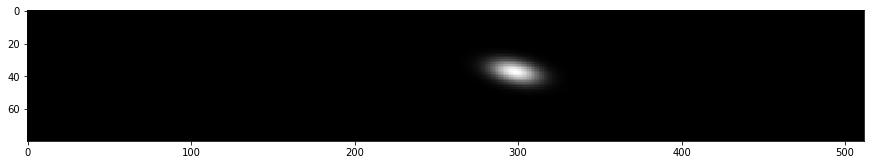

shape: (256, 256, 4), min: 0.0, max: 1.0


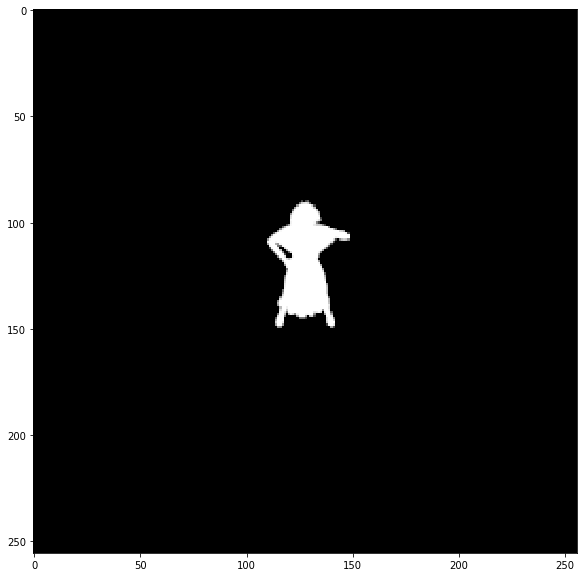

mitsuba finshed
shape: (256, 256, 3), min: 1.3005774235352874e-10, max: 1.0


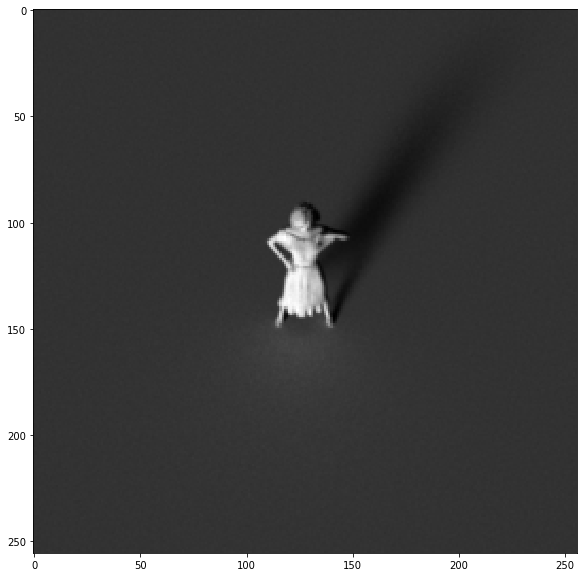

shape: (256, 256, 3), min: 0.30029296875, max: 1.0


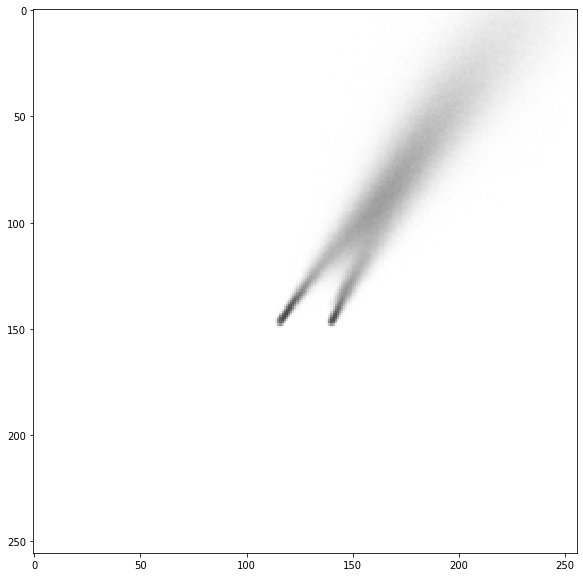

shape: (80, 512, 4), min: 0.0, max: 1.0


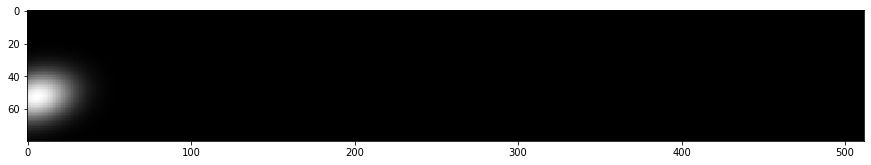

shape: (256, 256, 4), min: 0.0, max: 1.0


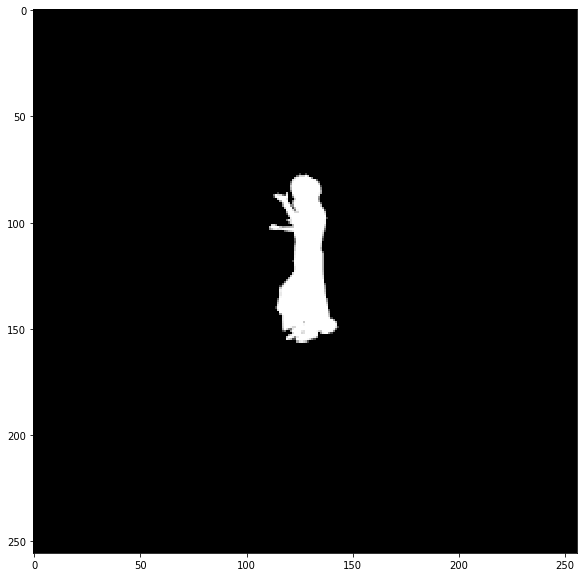

mitsuba finshed
shape: (256, 256, 3), min: 0.0, max: 1.0


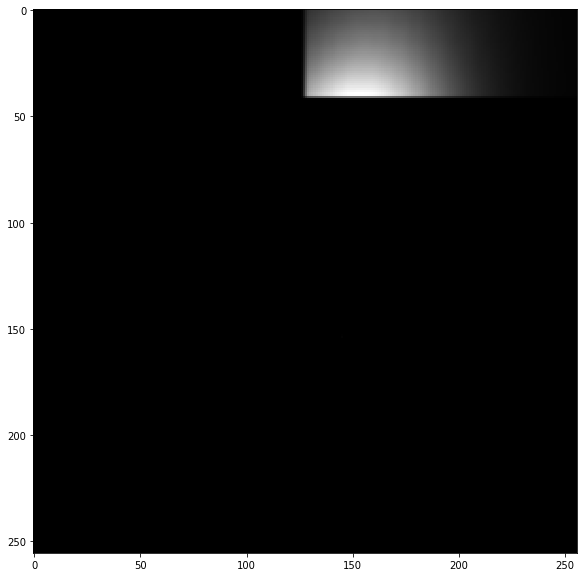

shape: (256, 256, 3), min: 0.94921875, max: 1.0


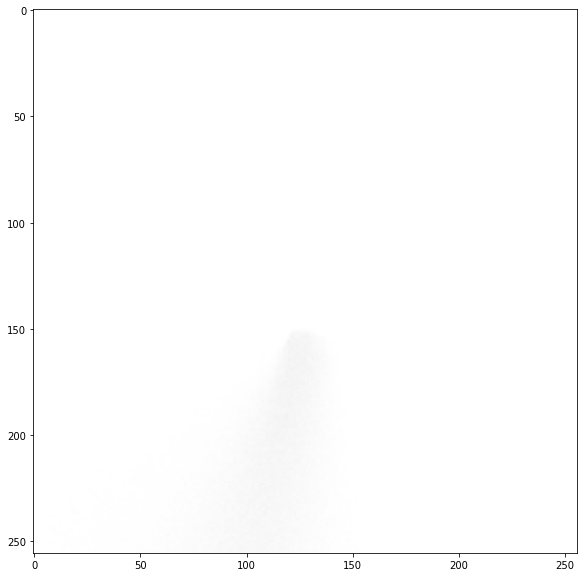

shape: (80, 512, 4), min: 0.0, max: 1.0


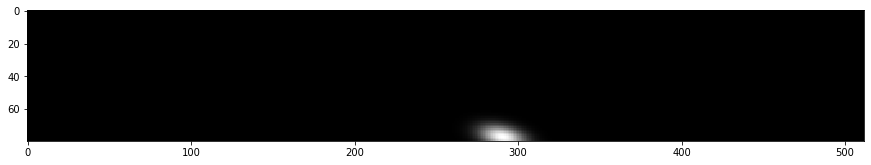

shape: (256, 256, 4), min: 0.0, max: 1.0


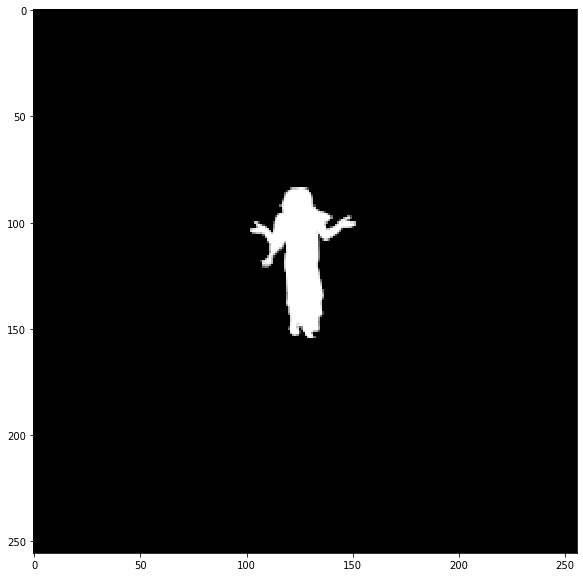

mitsuba finshed
shape: (256, 256, 3), min: 0.0, max: 1.0


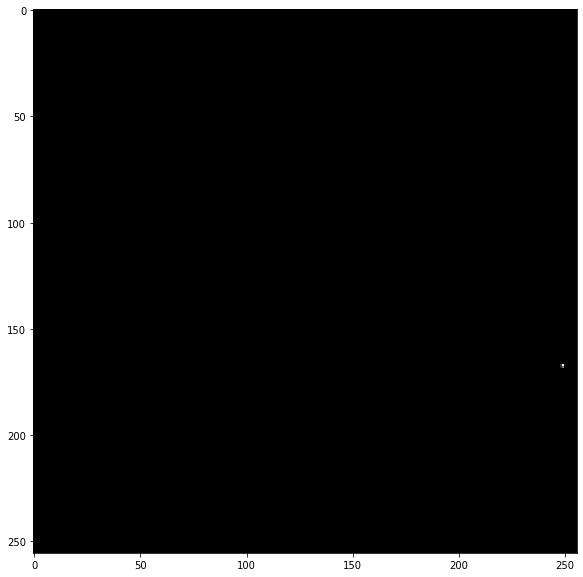

shape: (256, 256, 3), min: 1.0, max: 1.0


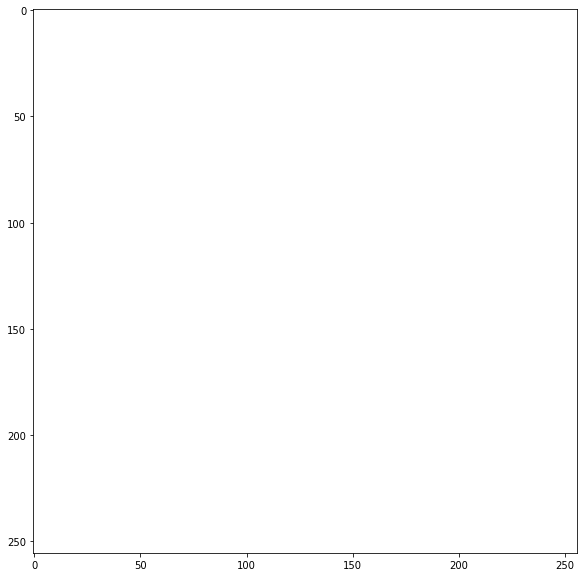

shape: (80, 512, 4), min: 0.0, max: 1.0


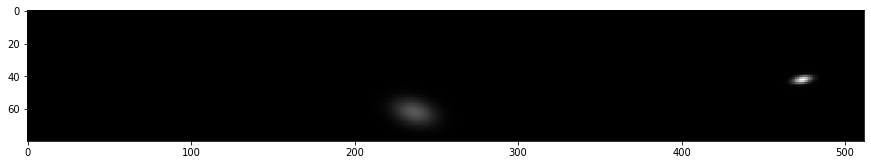

shape: (256, 256, 4), min: 0.0, max: 1.0


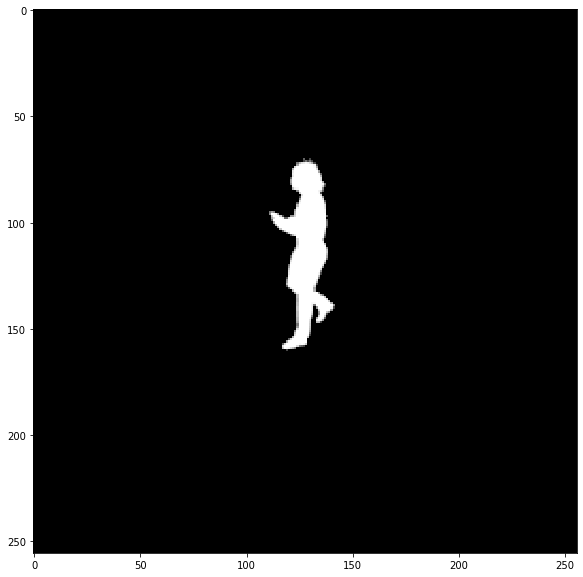

mitsuba finshed
shape: (256, 256, 3), min: 0.0, max: 1.0


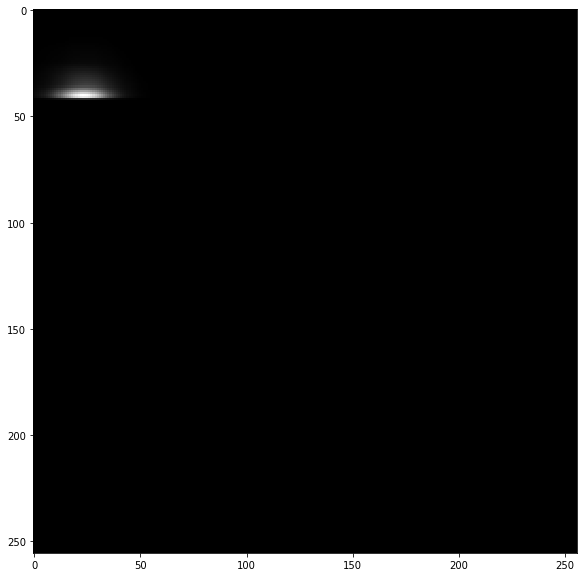

shape: (256, 256, 3), min: 0.98876953125, max: 1.0


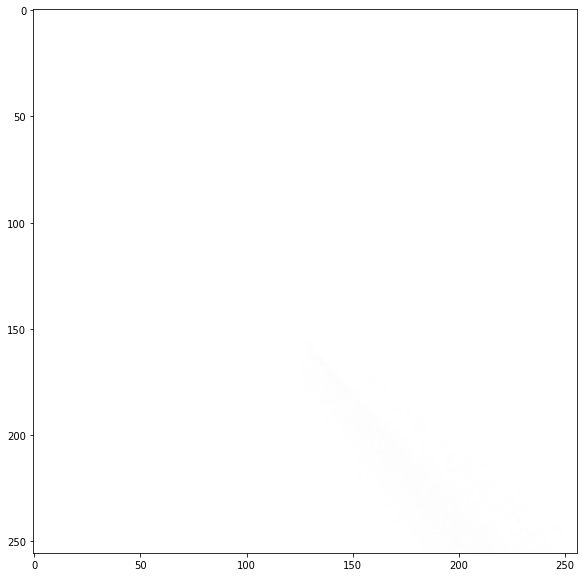

shape: (80, 512, 4), min: 0.0, max: 1.0


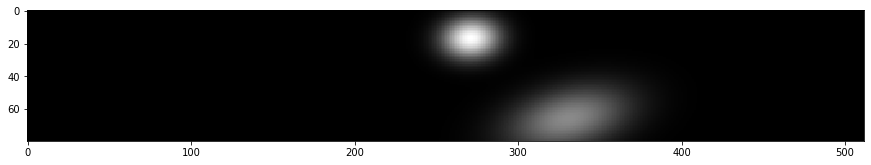

shape: (256, 256, 4), min: 0.0, max: 1.0


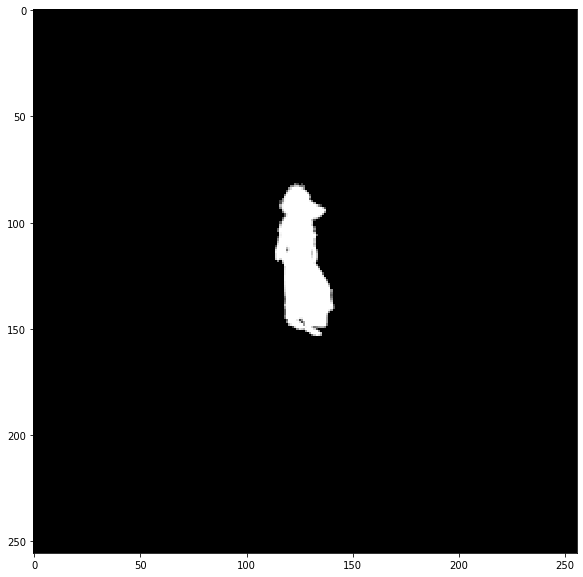

mitsuba finshed
shape: (256, 256, 3), min: 8.731149137020111e-10, max: 1.0


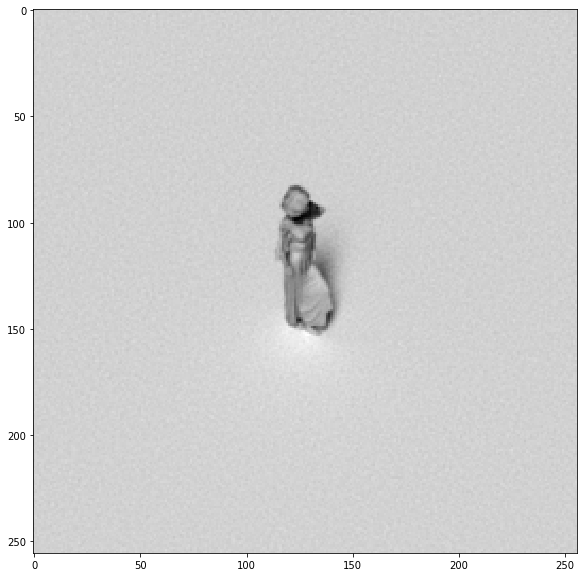

shape: (256, 256, 3), min: 0.396240234375, max: 1.0


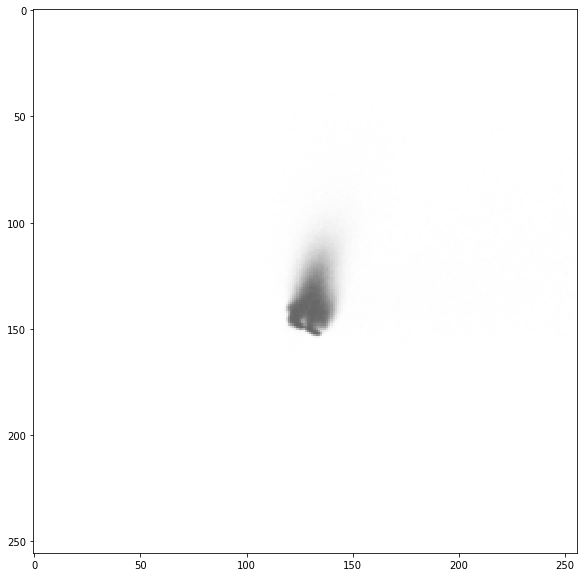

shape: (80, 512, 4), min: 0.0, max: 1.0


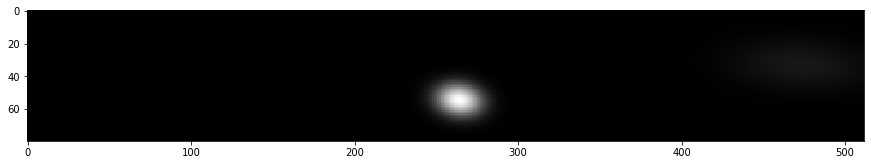

shape: (256, 256, 4), min: 0.0, max: 1.0


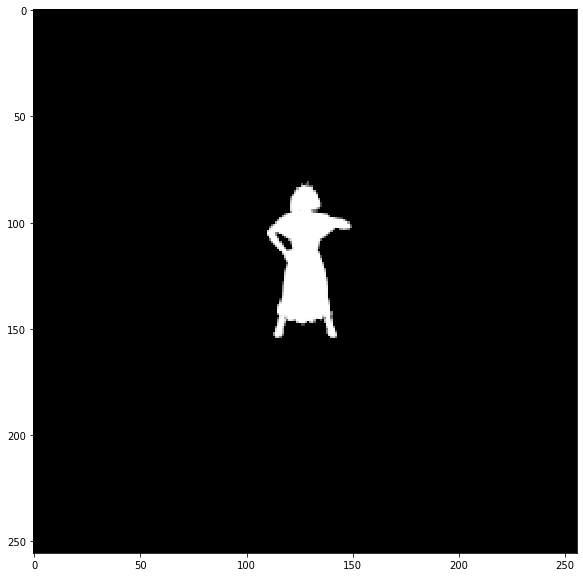

mitsuba finshed
shape: (256, 256, 3), min: 3.055902197957039e-10, max: 1.0


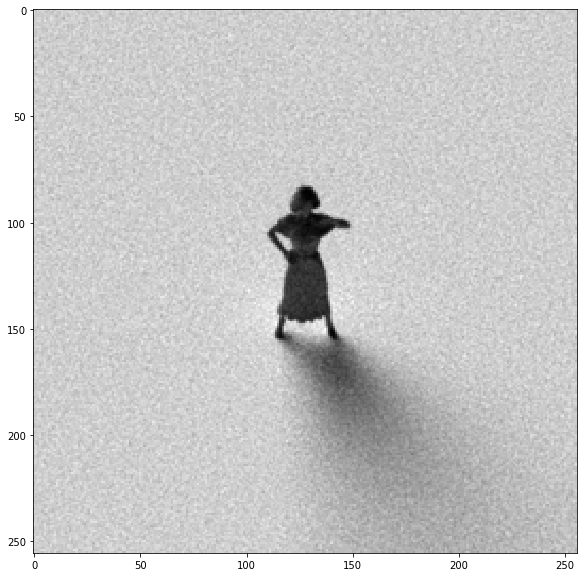

shape: (256, 256, 3), min: 0.94921875, max: 1.0


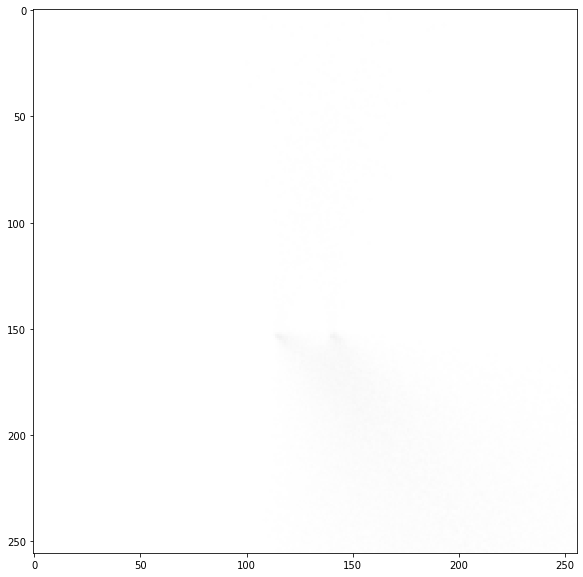

shape: (80, 512, 4), min: 0.0, max: 1.0


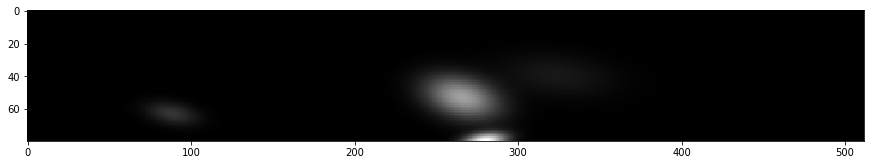

shape: (256, 256, 4), min: 0.0, max: 1.0


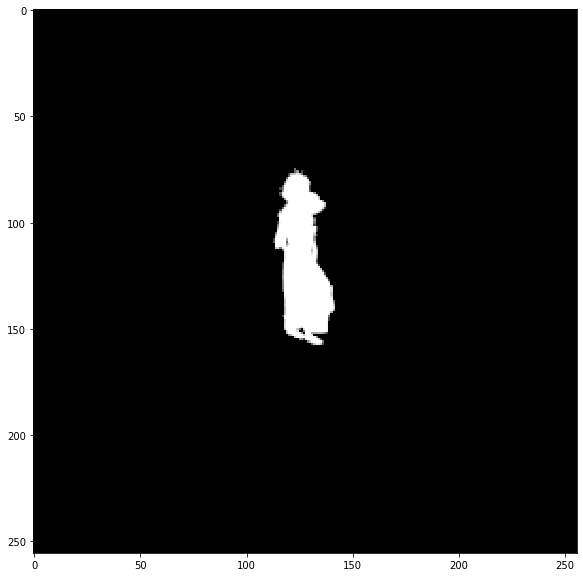

mitsuba finshed
shape: (256, 256, 3), min: 0.0, max: 1.0


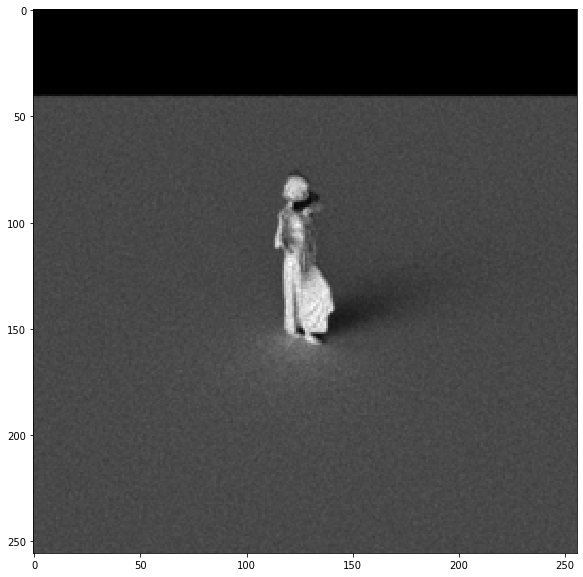

shape: (256, 256, 3), min: 0.94677734375, max: 1.0


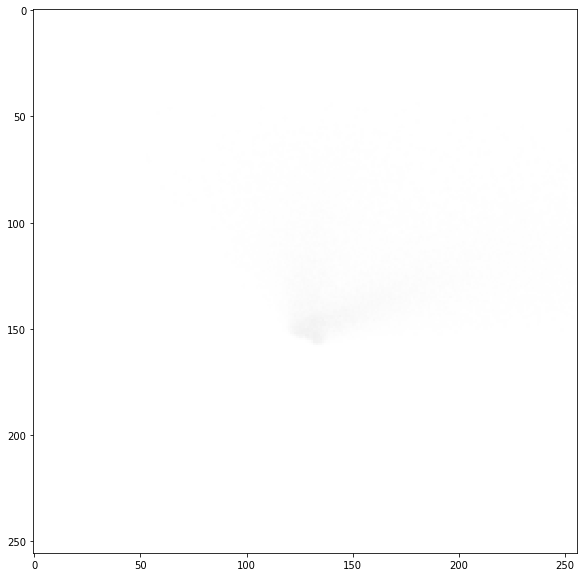

shape: (80, 512, 4), min: 0.0, max: 1.0


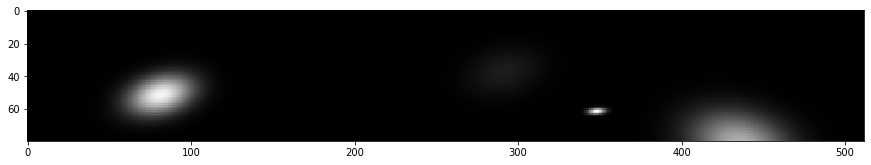

shape: (256, 256, 4), min: 0.0, max: 1.0


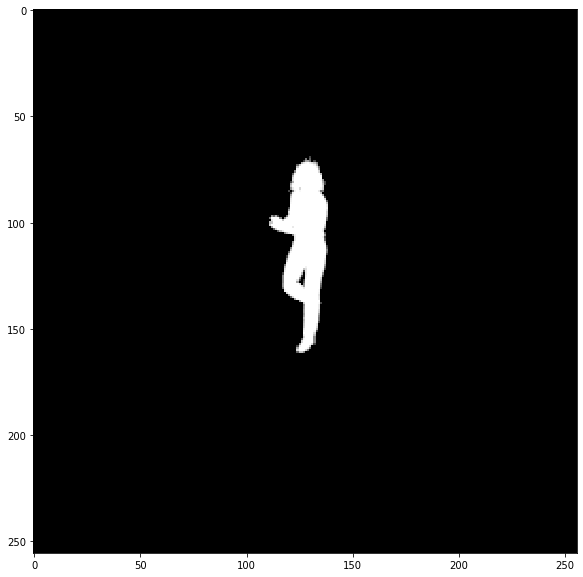

mitsuba finshed
shape: (256, 256, 3), min: 0.0, max: 0.9999999403953552


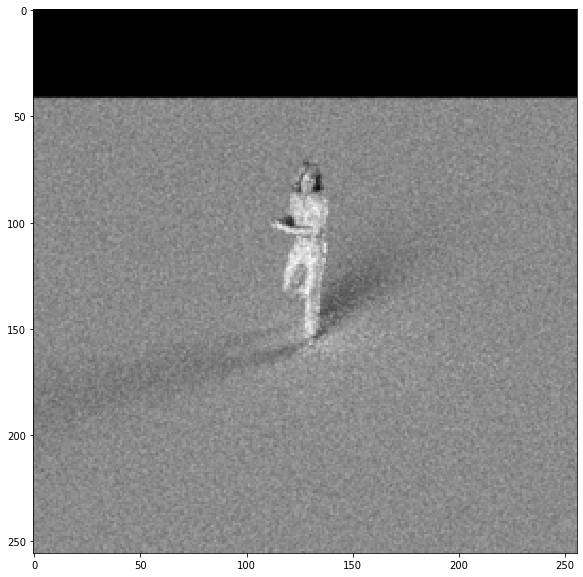

shape: (256, 256, 3), min: 0.9736328125, max: 1.0


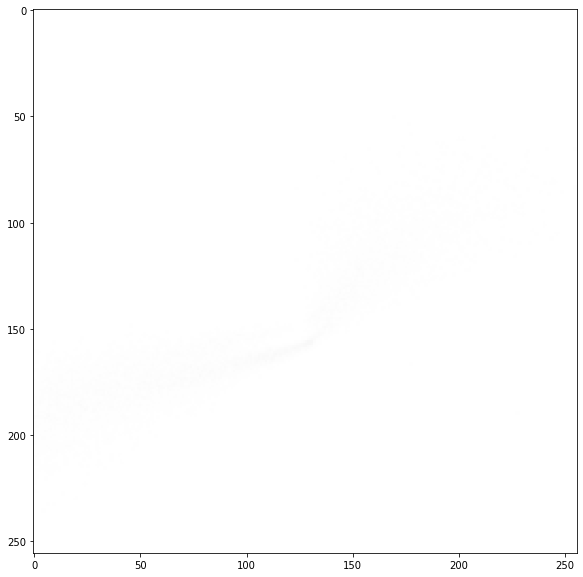

shape: (80, 512, 4), min: 0.0, max: 1.0


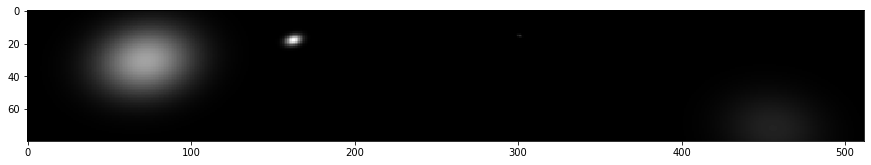

shape: (256, 256, 4), min: 0.0, max: 1.0


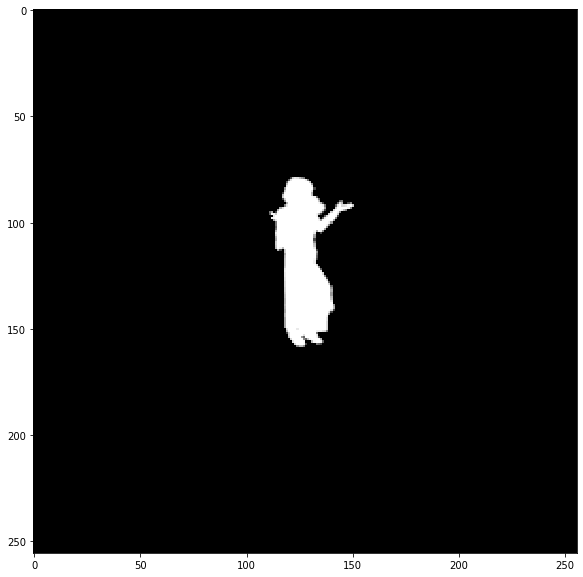

mitsuba finshed
shape: (256, 256, 3), min: 0.0, max: 1.0


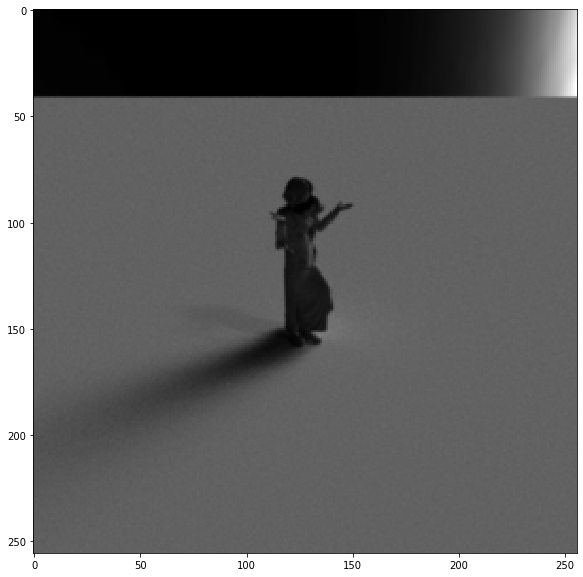

shape: (256, 256, 3), min: 0.2269287109375, max: 1.0


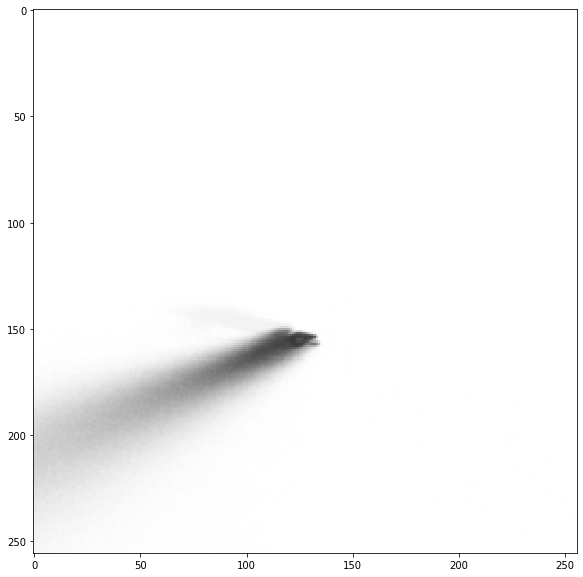

shape: (80, 512, 4), min: 0.0, max: 1.0


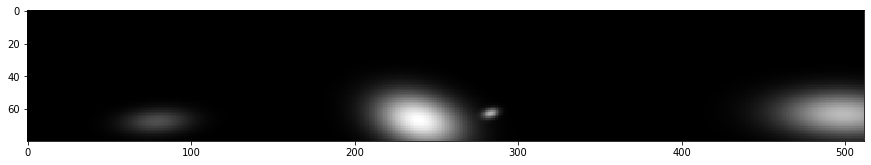

shape: (256, 256, 4), min: 0.0, max: 1.0


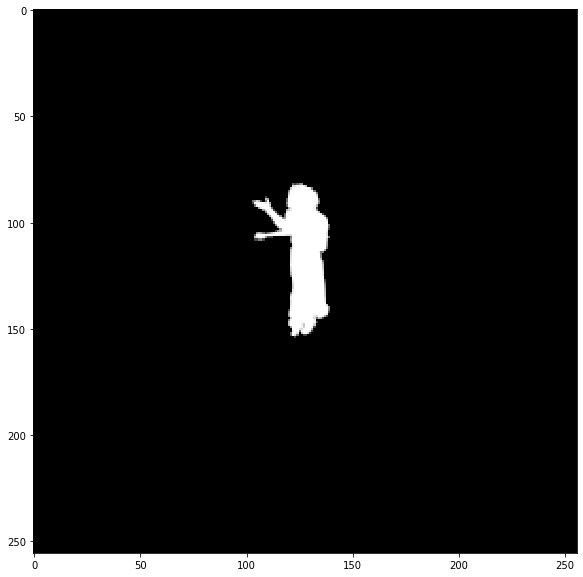

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mitsuba finshed
shape: (256, 256, 3), min: -2.3283064365386963e-10, max: 1.0


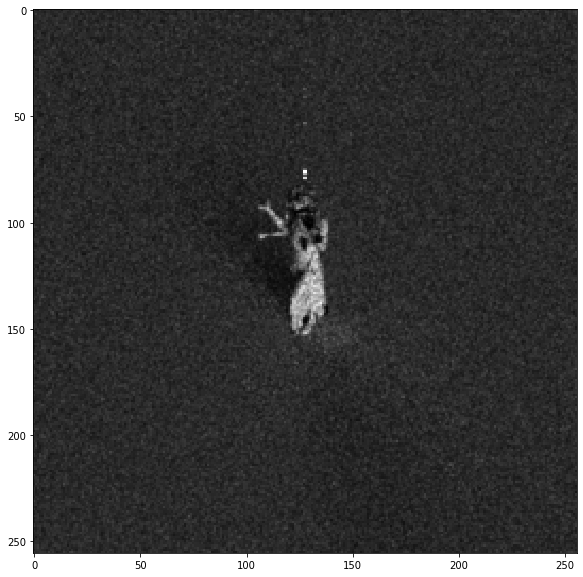

shape: (256, 256, 3), min: 0.99609375, max: 1.0


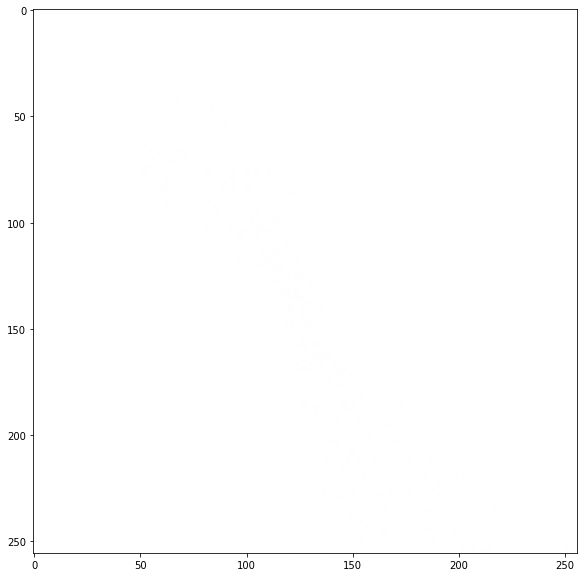

shape: (80, 512, 4), min: 0.0, max: 1.0


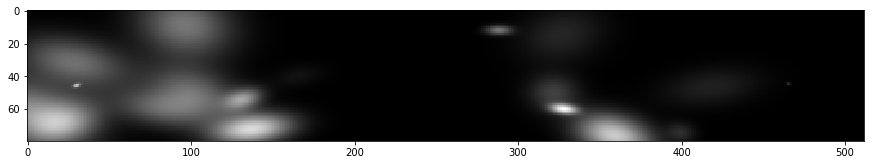

shape: (256, 256, 4), min: 0.0, max: 1.0


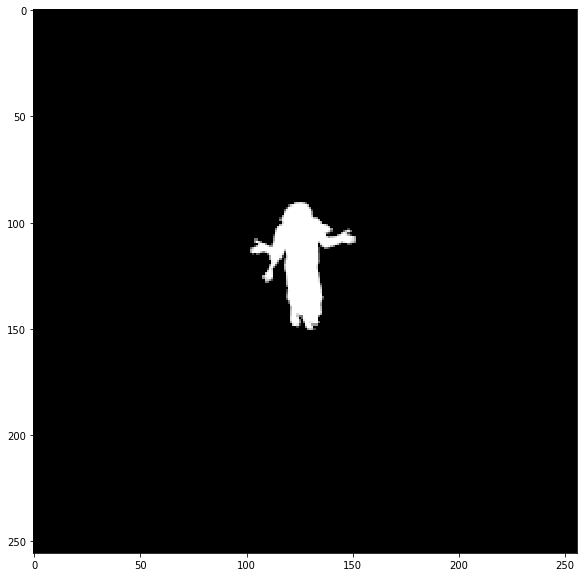

mitsuba finshed
shape: (256, 256, 3), min: 3.23325366480276e-10, max: 1.0


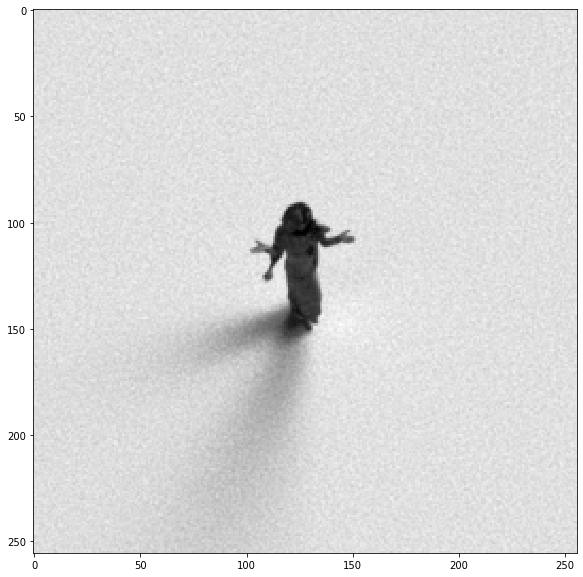

shape: (256, 256, 3), min: 0.759765625, max: 1.0


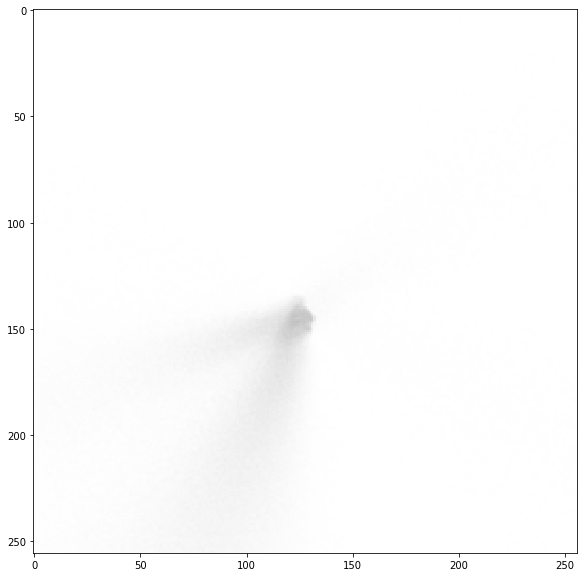

shape: (80, 512, 4), min: 0.0, max: 1.0


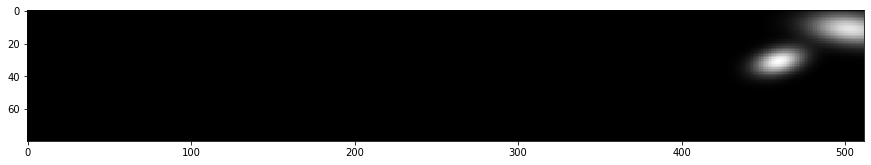

shape: (256, 256, 4), min: 0.0, max: 1.0


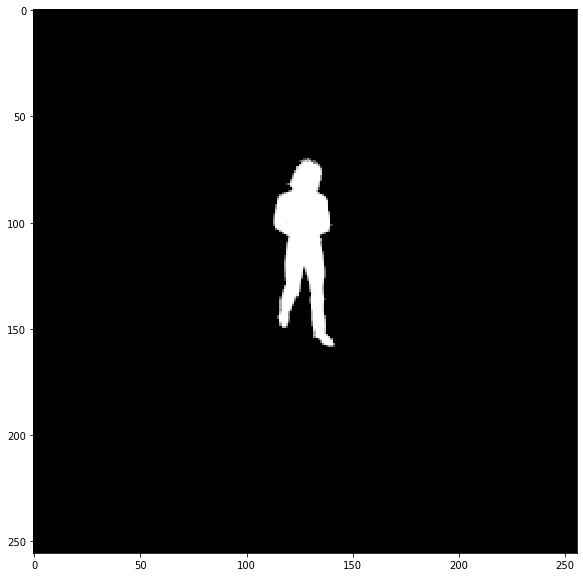

mitsuba finshed
shape: (256, 256, 3), min: 0.0, max: 0.9999999403953552


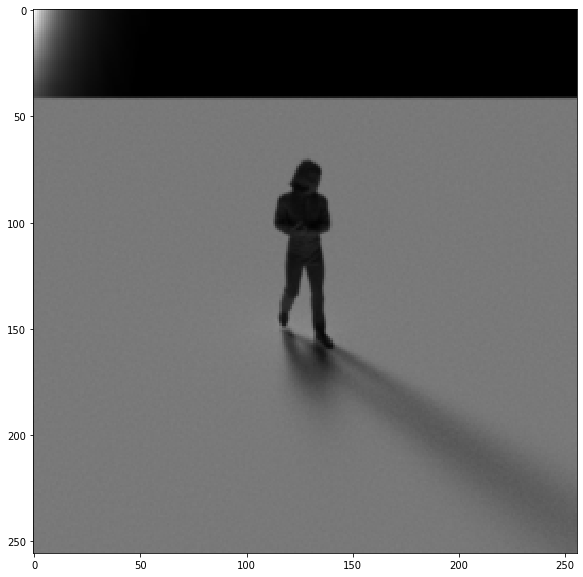

shape: (256, 256, 3), min: 0.0294952392578125, max: 1.0


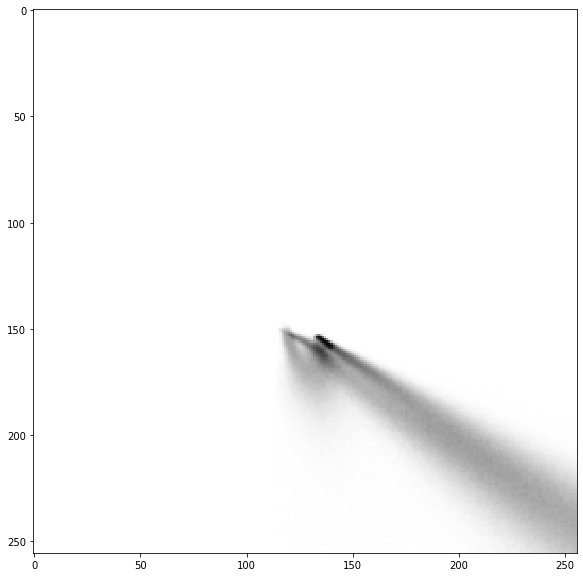

shape: (80, 512, 4), min: 0.0, max: 1.0


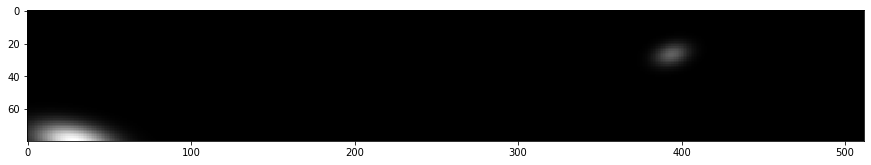

shape: (256, 256, 4), min: 0.0, max: 1.0


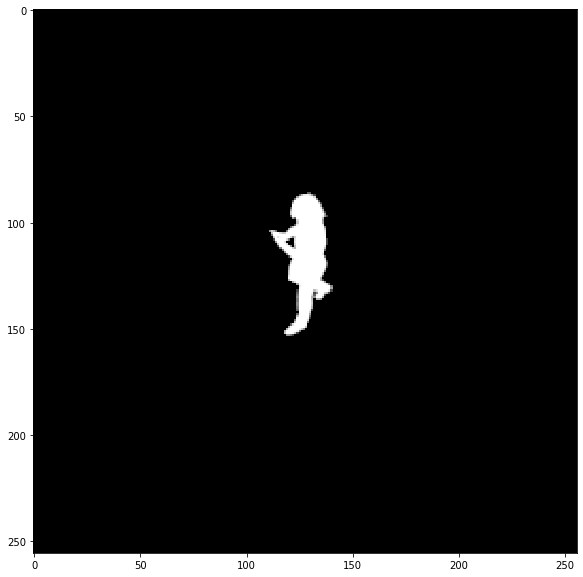

mitsuba finshed
shape: (256, 256, 3), min: 6.111804395914078e-10, max: 1.0


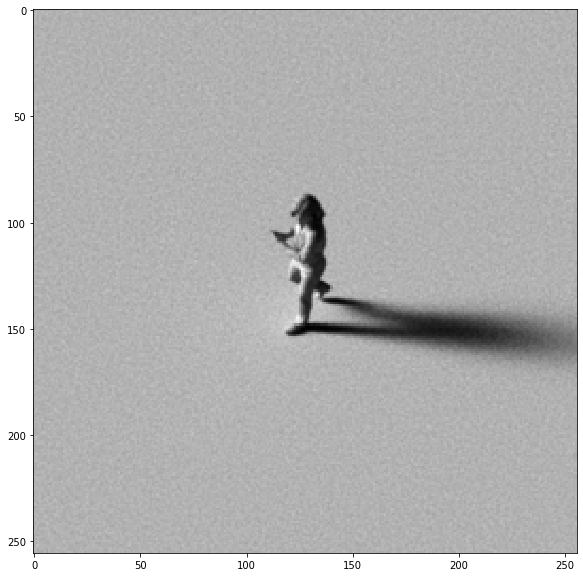

shape: (256, 256, 3), min: 0.673828125, max: 1.0


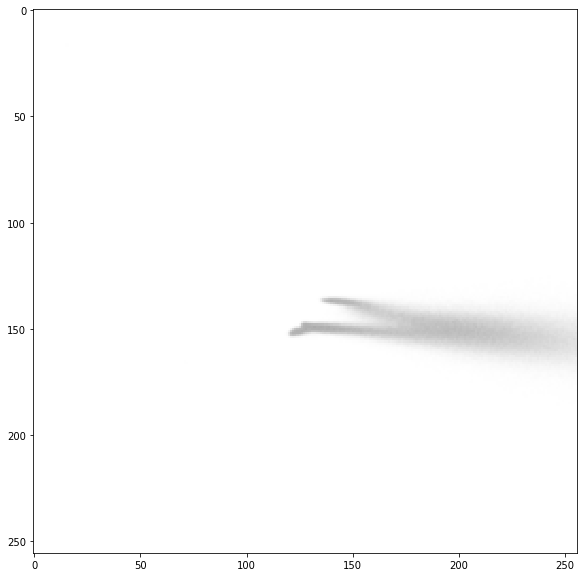

shape: (80, 512, 4), min: 0.0, max: 1.0


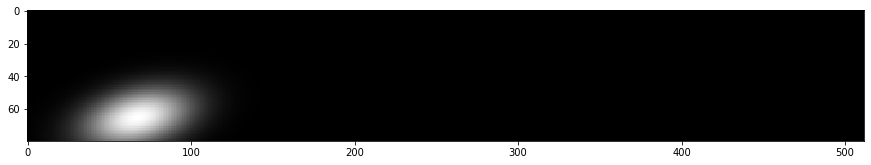

shape: (256, 256, 4), min: 0.0, max: 1.0


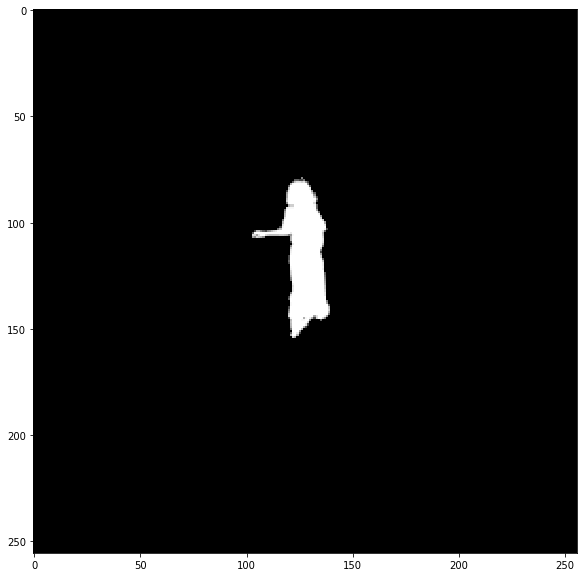

mitsuba finshed
shape: (256, 256, 3), min: 0.0, max: 1.0


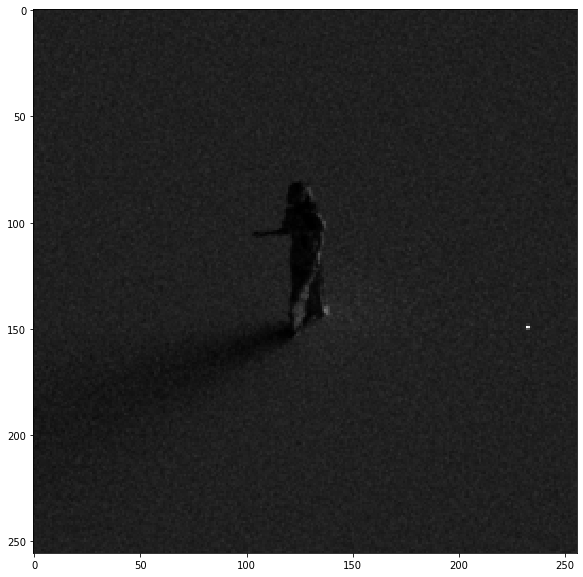

shape: (256, 256, 3), min: 0.99072265625, max: 1.0


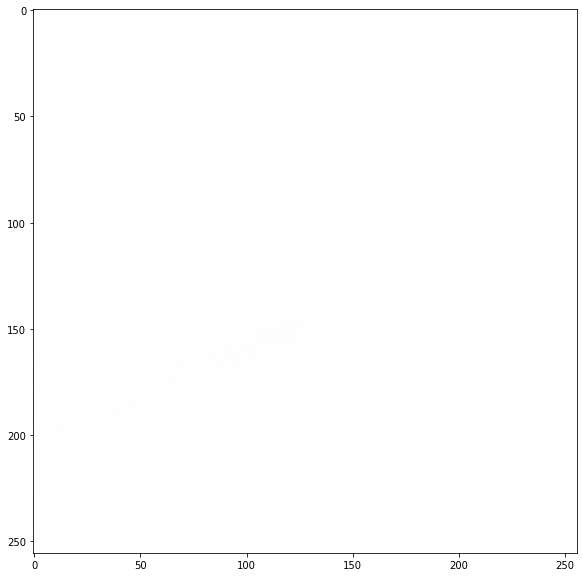

shape: (80, 512, 4), min: 0.0, max: 1.0


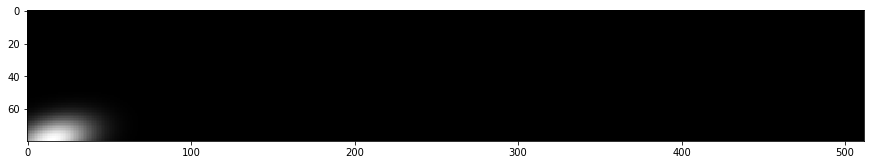

shape: (256, 256, 4), min: 0.0, max: 1.0


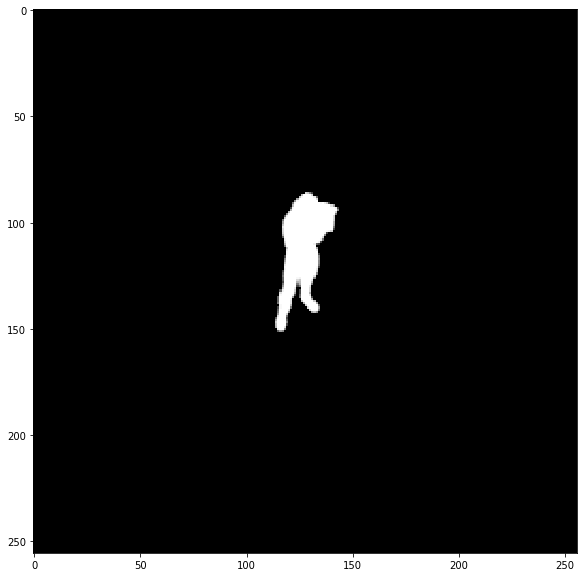

mitsuba finshed
shape: (256, 256, 3), min: 0.0, max: 1.0


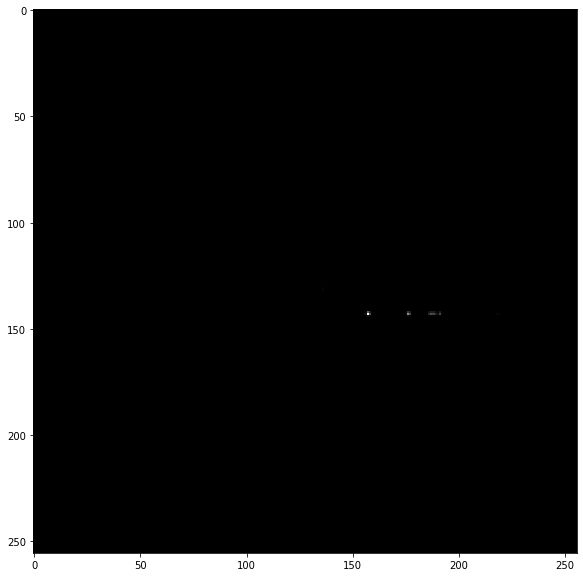

shape: (256, 256, 3), min: 1.0, max: 1.0


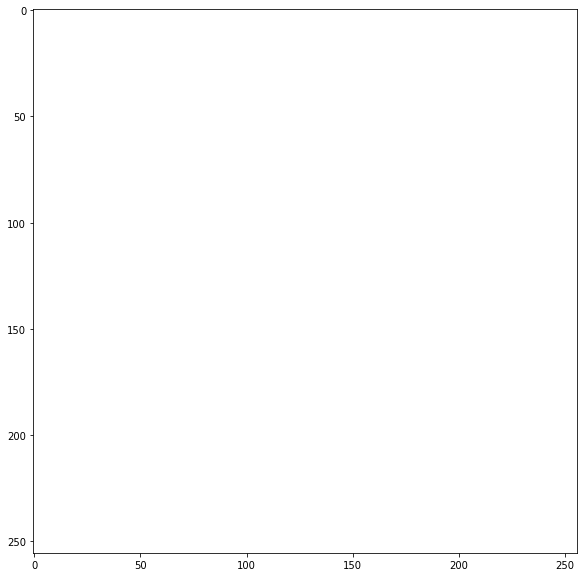

shape: (80, 512, 4), min: 0.0, max: 1.0


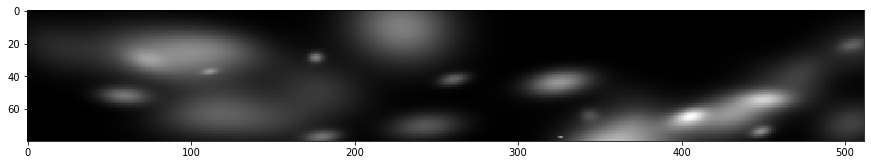

shape: (256, 256, 4), min: 0.0, max: 1.0


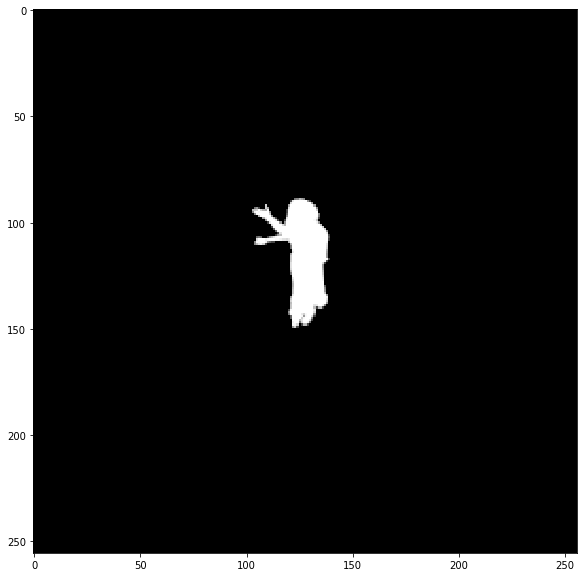

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mitsuba finshed
shape: (256, 256, 3), min: -8.36735125631094e-11, max: 1.0


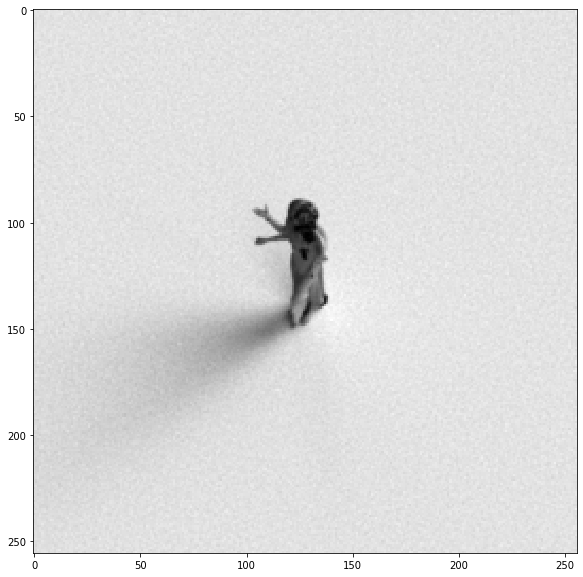

shape: (256, 256, 3), min: 0.5703125, max: 1.0


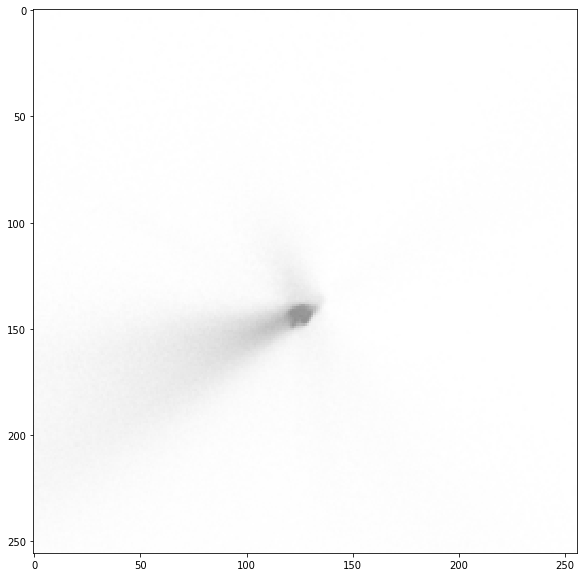

shape: (80, 512, 4), min: 0.0, max: 1.0


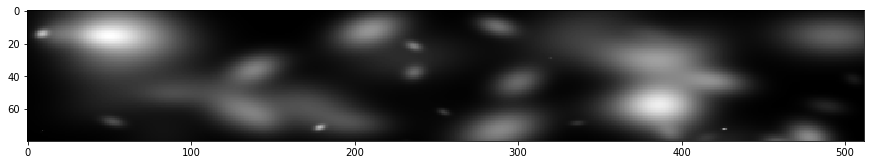

shape: (256, 256, 4), min: 0.0, max: 1.0


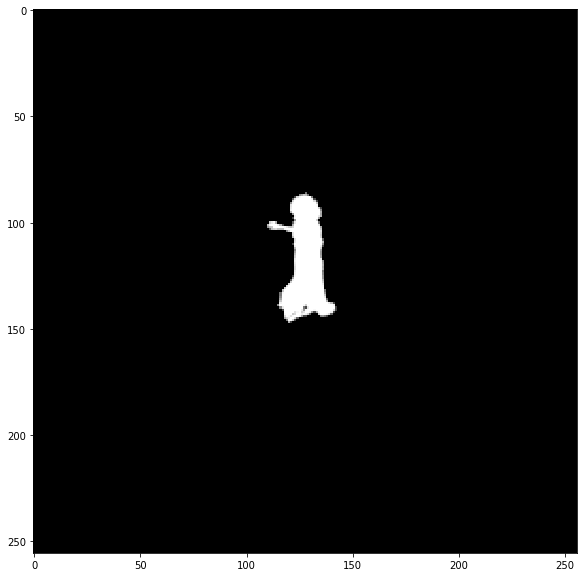

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mitsuba finshed
shape: (256, 256, 3), min: -4.001776687800884e-11, max: 0.9999999403953552


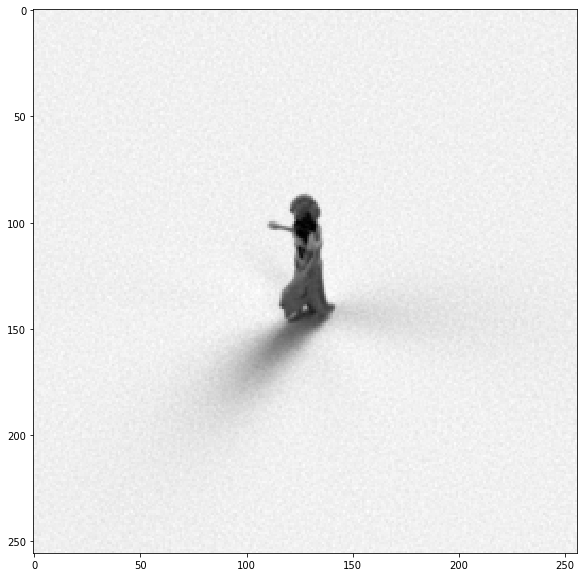

shape: (256, 256, 3), min: 0.5078125, max: 1.0


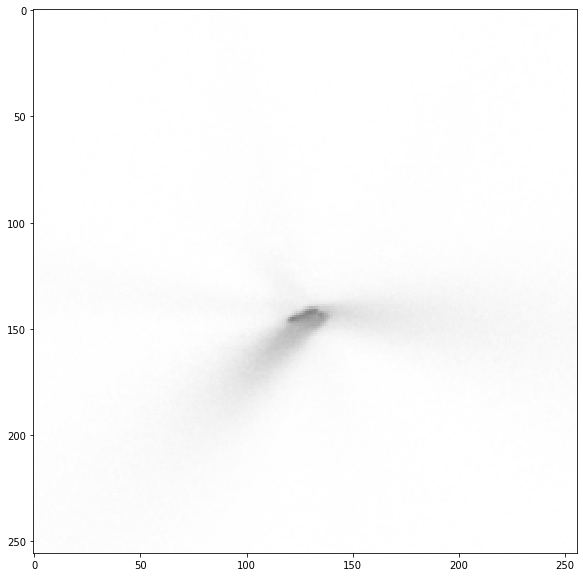

shape: (80, 512, 4), min: 0.0, max: 1.0


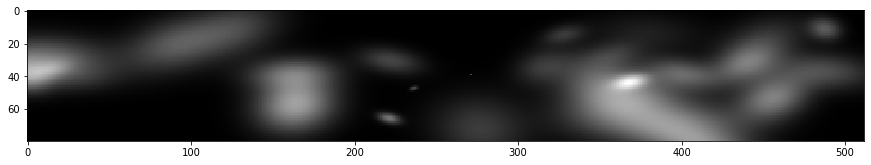

shape: (256, 256, 4), min: 0.0, max: 1.0


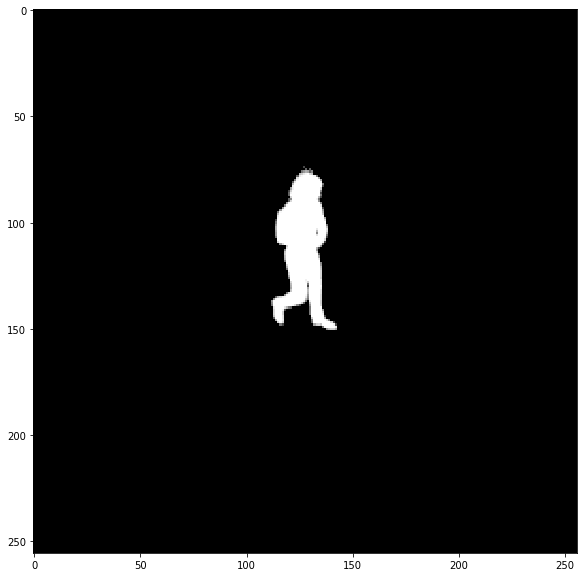

mitsuba finshed
shape: (256, 256, 3), min: 7.203198038041592e-10, max: 1.0


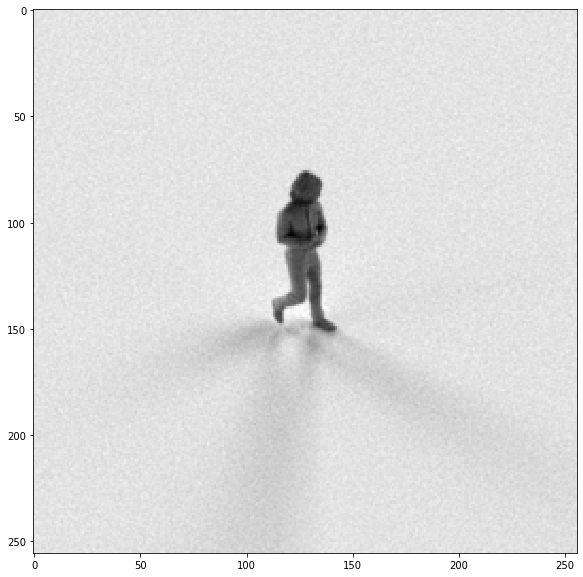

shape: (256, 256, 3), min: 0.6943359375, max: 1.0


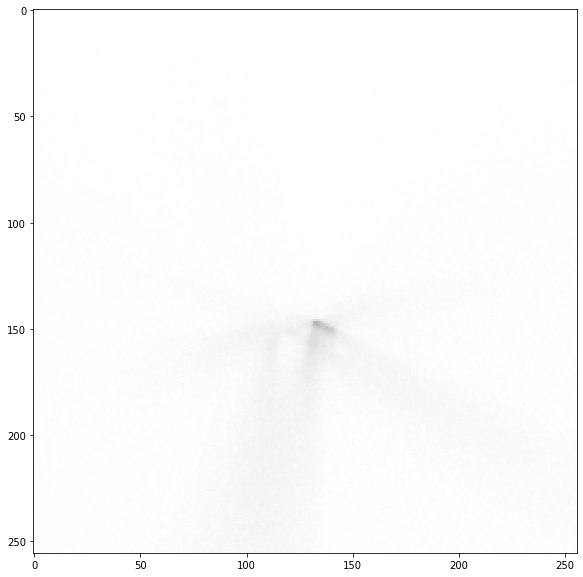

shape: (80, 512, 4), min: 0.0, max: 1.0


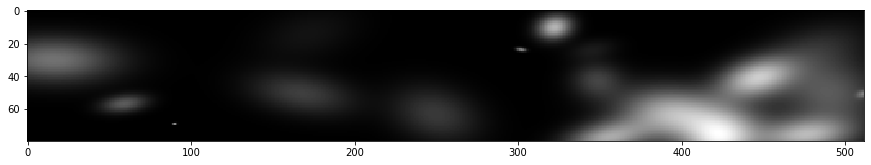

shape: (256, 256, 4), min: 0.0, max: 1.0


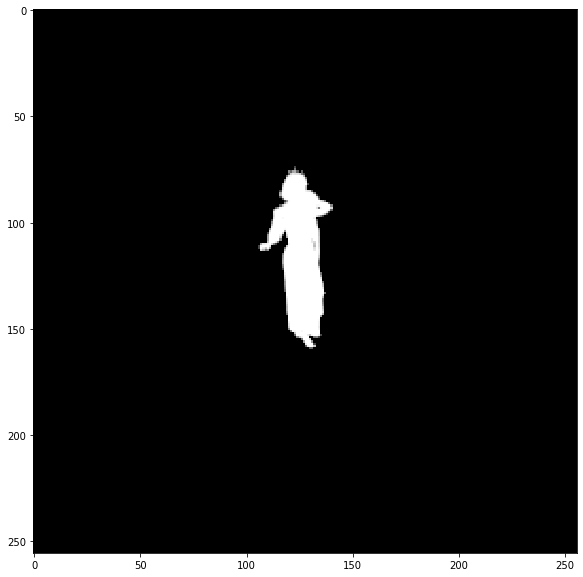

mitsuba finshed
shape: (256, 256, 3), min: 8.526512829121202e-13, max: 1.0


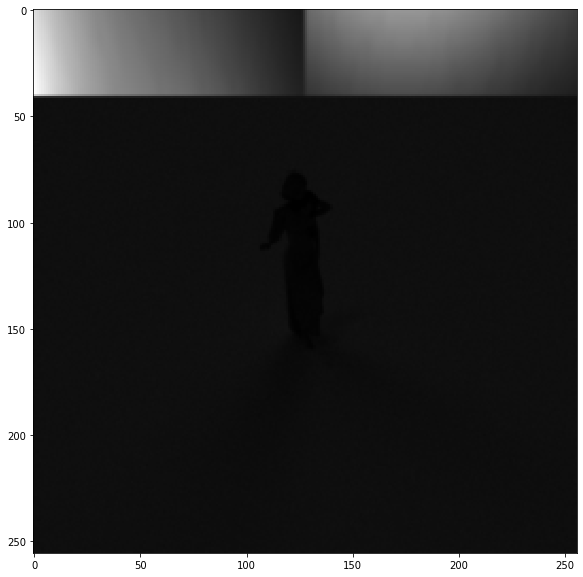

shape: (256, 256, 3), min: 0.7958984375, max: 1.0


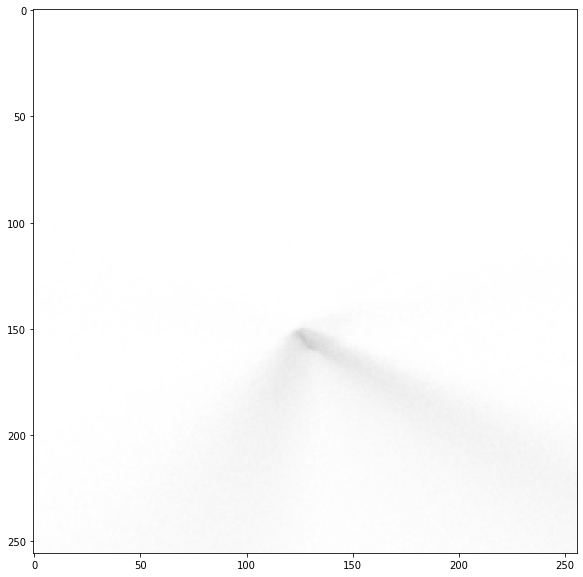

shape: (80, 512, 4), min: 0.0, max: 1.0


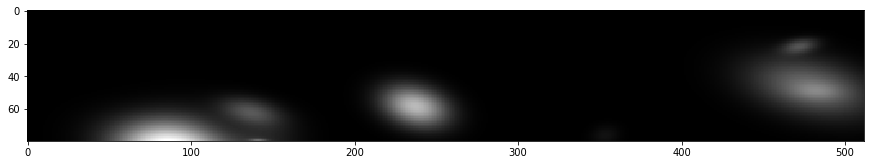

shape: (256, 256, 4), min: 0.0, max: 1.0


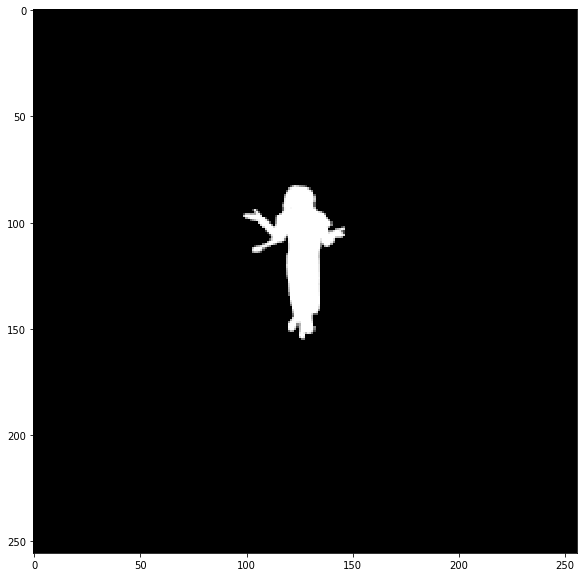

mitsuba finshed
shape: (256, 256, 3), min: 7.275957614183426e-12, max: 1.0


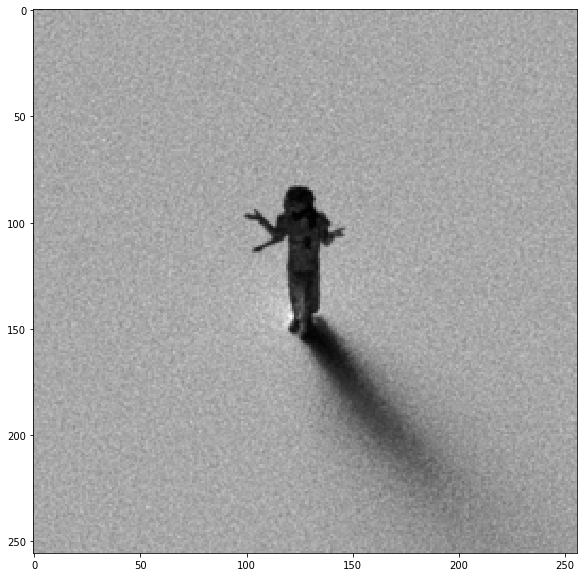

shape: (256, 256, 3), min: 0.896484375, max: 1.0


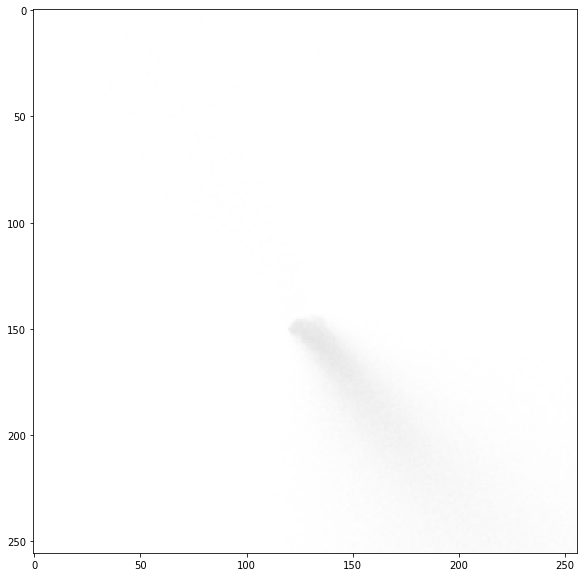

In [50]:
def get_fname(fpath):
    return os.path.splitext(os.path.basename(fpath))[0]

# prepare mitsuba result
user_study_result = 'user_study_result'
os.makedirs(user_study_result, exist_ok=True)

for i in range(len(us_ibls)):
    ibl, mask = us_ibls[i], us_mask[i]
    ibl_np, mask_np = plt.imread(ibl), plt.imread(mask)
    show(ibl_np)
    show(mask_np)
    
    ibl_name, mask_name = get_fname(ibl), get_fname(mask)
    prefix = '{}_{}'.format(ibl_name, mask_name)
    final_out, shadow_out = join(user_study_result, '{}_final.exr'.format(prefix)), join(user_study_result, '{}_shadow.exr'.format(prefix))
    
    mitsuba_render(mask, ibl, final_out, shadow_out, real_ibl=False)
    final_np, shadow_np = imageio.imread(final_out), imageio.imread(shadow_out)
    cv2.normalize(final_np,final_np, 0.0, 1.0, cv2.NORM_MINMAX)
    show(final_np)
    show(shadow_np)

In [37]:
# prepare net renderign result

